# P/E Ratio Mean Reversion Strategy

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product

In [3]:
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

## Set Stock Parameters

In [3]:
stock_symbol = "AAPL"
benchmark_symbol = "^GSPC"
start="2015-01-01"
end="2019-12-31"
period = "1y"

## Functions

In [4]:
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df

# add a PE column to the stock data
def calculate_pe_ratio(df, stock_symbol):
    ticker = yf.Ticker(stock_symbol)
    pe_ratio = ticker.info['forwardPE']
    df['PE_Ratio'] = pe_ratio
    return df

# set MA window and std dev (21-day, std_dev = 1)
def mean_reversion_strategy(df, window, std_dev):

    df['PE_MA'] = df['PE_Ratio'].rolling(window=window).mean()
    df['PE_STD'] = df['PE_Ratio'].rolling(window=window).std()
    
    df['Upper_Band'] = df['PE_MA'] + (std_dev * df['PE_STD'])
    df['Lower_Band'] = df['PE_MA'] - (std_dev * df['PE_STD'])
    
    df['Signal'] = np.where(df['PE_Ratio'] > df['Upper_Band'], -1, 
                            np.where(df['PE_Ratio'] < df['Lower_Band'], 1, 0))
    
    return df

def backtest_strategy(df):
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']
    
    cumulative_returns = (1 + df['Returns']).cumprod()
    cumulative_strategy_returns = (1 + df['Strategy_Returns']).cumprod()
    
    return cumulative_returns, cumulative_strategy_returns


## Run Functions

<Axes: xlabel='Date'>

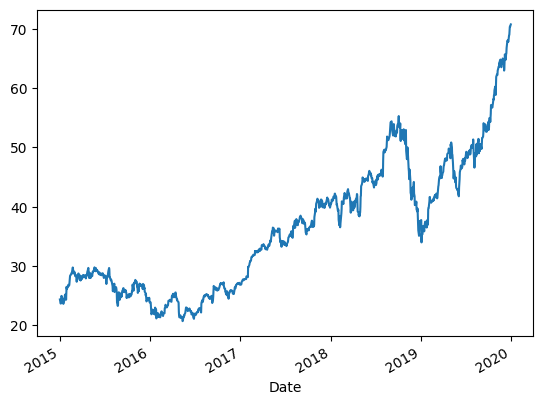

In [5]:
stock_data = yf.Ticker(stock_symbol)
hist_stock = stock_data.history(start=start, end=end)
hist_stock["Close"].plot()

Buy and Hold Returns: 2.90
Strategy Returns: 0.85


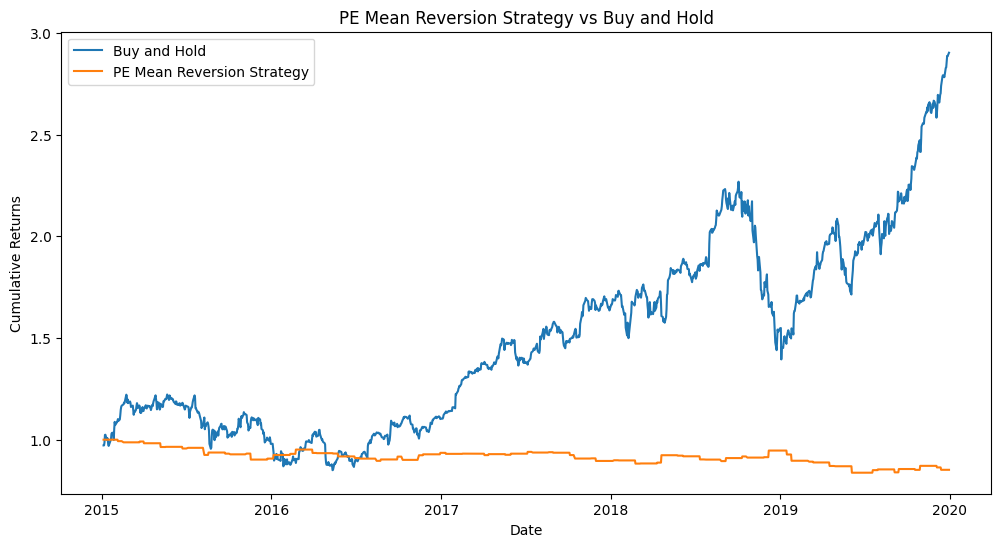

In [6]:
df = get_stock_data(stock_symbol, start, end)
df = calculate_pe_ratio(df, stock_symbol)
df = mean_reversion_strategy(df, window= 21, std_dev= 1)

cumulative_returns, cumulative_strategy_returns = backtest_strategy(df)

print(f"Buy and Hold Returns: {cumulative_returns.iloc[-1]:.2f}")
print(f"Strategy Returns: {cumulative_strategy_returns.iloc[-1]:.2f}")

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Buy and Hold')
plt.plot(cumulative_strategy_returns, label='PE Mean Reversion Strategy')
plt.title('PE Mean Reversion Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## Try for all MAANG Stocks


META:
Buy and Hold Returns: 2.61
Strategy Returns: 1.17

AAPL:
Buy and Hold Returns: 2.90
Strategy Returns: 0.81

AMZN:
Buy and Hold Returns: 5.99
Strategy Returns: 1.30

NFLX:
Buy and Hold Returns: 6.49
Strategy Returns: 1.51

GOOGL:
Buy and Hold Returns: 2.53
Strategy Returns: 0.80


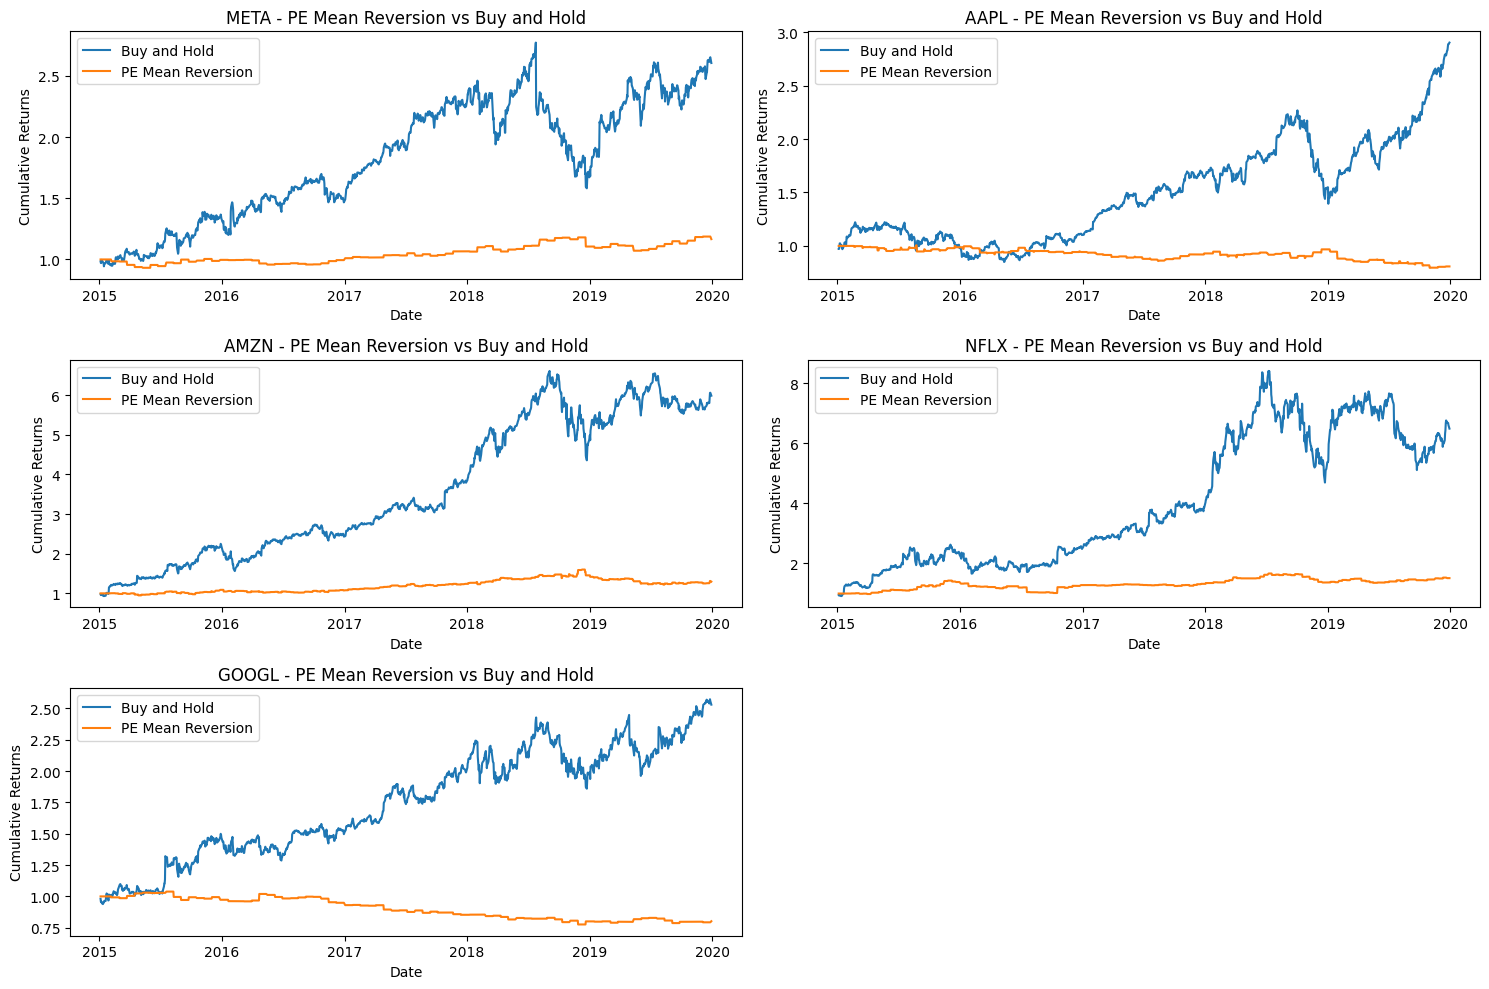

In [24]:

def pe_mean_reversion_strategy(tickers, start_date, end_date, window=21, std_dev=100):
    results = {}

    for ticker in tickers:
        # Fetch stock data
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        # Calculate PE ratio (using forward PE)
        pe_ratio = stock.info.get('forwardPE')
        if pe_ratio is None:
            print(f"Warning: Forward PE not available for {ticker}. Skipping.")
            continue
        df['PE_Ratio'] = pe_ratio

        # Calculate moving average and standard deviation
        df['PE_MA'] = df['PE_Ratio'].rolling(window=window).mean()
        df['PE_STD'] = df['PE_Ratio'].rolling(window=window).std()

        # Generate buy/sell signals
        df['Upper_Band'] = df['PE_MA'] + (std_dev * df['PE_STD'])
        df['Lower_Band'] = df['PE_MA'] - (std_dev * df['PE_STD'])
        df['Signal'] = np.where(df['PE_Ratio'] > df['Upper_Band'], 1, 
                                np.where(df['PE_Ratio'] < df['Lower_Band'], -1, 0))

        # Calculate returns
        df['Returns'] = df['Close'].pct_change()
        df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

        # Calculate cumulative returns
        cumulative_returns = (1 + df['Returns']).cumprod()
        cumulative_strategy_returns = (1 + df['Strategy_Returns']).cumprod()

        results[ticker] = {
            'Buy_and_Hold': cumulative_returns.iloc[-1],
            'Strategy': cumulative_strategy_returns.iloc[-1],
            'Cumulative_Returns': cumulative_returns,
            'Cumulative_Strategy_Returns': cumulative_strategy_returns
        }

    return results

# Main execution
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']

results = pe_mean_reversion_strategy(tickers, start, end)

# Print results
for ticker, data in results.items():
    print(f"\n{ticker}:")
    print(f"Buy and Hold Returns: {data['Buy_and_Hold']:.2f}")
    print(f"Strategy Returns: {data['Strategy']:.2f}")

# Plot results
plt.figure(figsize=(15, 10))
for i, (ticker, data) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(data['Cumulative_Returns'], label='Buy and Hold')
    plt.plot(data['Cumulative_Strategy_Returns'], label='PE Mean Reversion')
    plt.title(f'{ticker} - PE Mean Reversion vs Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()

plt.tight_layout()
plt.show()

### Optimisation

Processing META...
Processing AAPL...


/var/folders/18/wfgp52jj6rb7zsb485dxh1dh0000gn/T/ipykernel_1197/2907735153.py:35: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()
/var/folders/18/wfgp52jj6rb7zsb485dxh1dh0000gn/T/ipykernel_1197/2907735153.py:35: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()


Processing AMZN...
Processing NFLX...
Processing GOOGL...

META:
Buy and Hold Returns: 2.61
Strategy Returns: 2.13
Sharpe Ratio: 1.02
Best Parameters (Window, Std Dev): (60, 0.5)

AAPL:
Buy and Hold Returns: 2.90
Strategy Returns: 1.54
Sharpe Ratio: 0.85
Best Parameters (Window, Std Dev): (90, 0.5)

AMZN:
Buy and Hold Returns: 5.99
Strategy Returns: 1.78
Sharpe Ratio: 1.05
Best Parameters (Window, Std Dev): (50, 0.5)

NFLX:
Buy and Hold Returns: 6.49
Strategy Returns: 1.78
Sharpe Ratio: 0.78
Best Parameters (Window, Std Dev): (90, 0.5)

GOOGL:
Buy and Hold Returns: 2.53
Strategy Returns: 1.64
Sharpe Ratio: 0.79
Best Parameters (Window, Std Dev): (70, 0.5)


/var/folders/18/wfgp52jj6rb7zsb485dxh1dh0000gn/T/ipykernel_1197/2907735153.py:35: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()


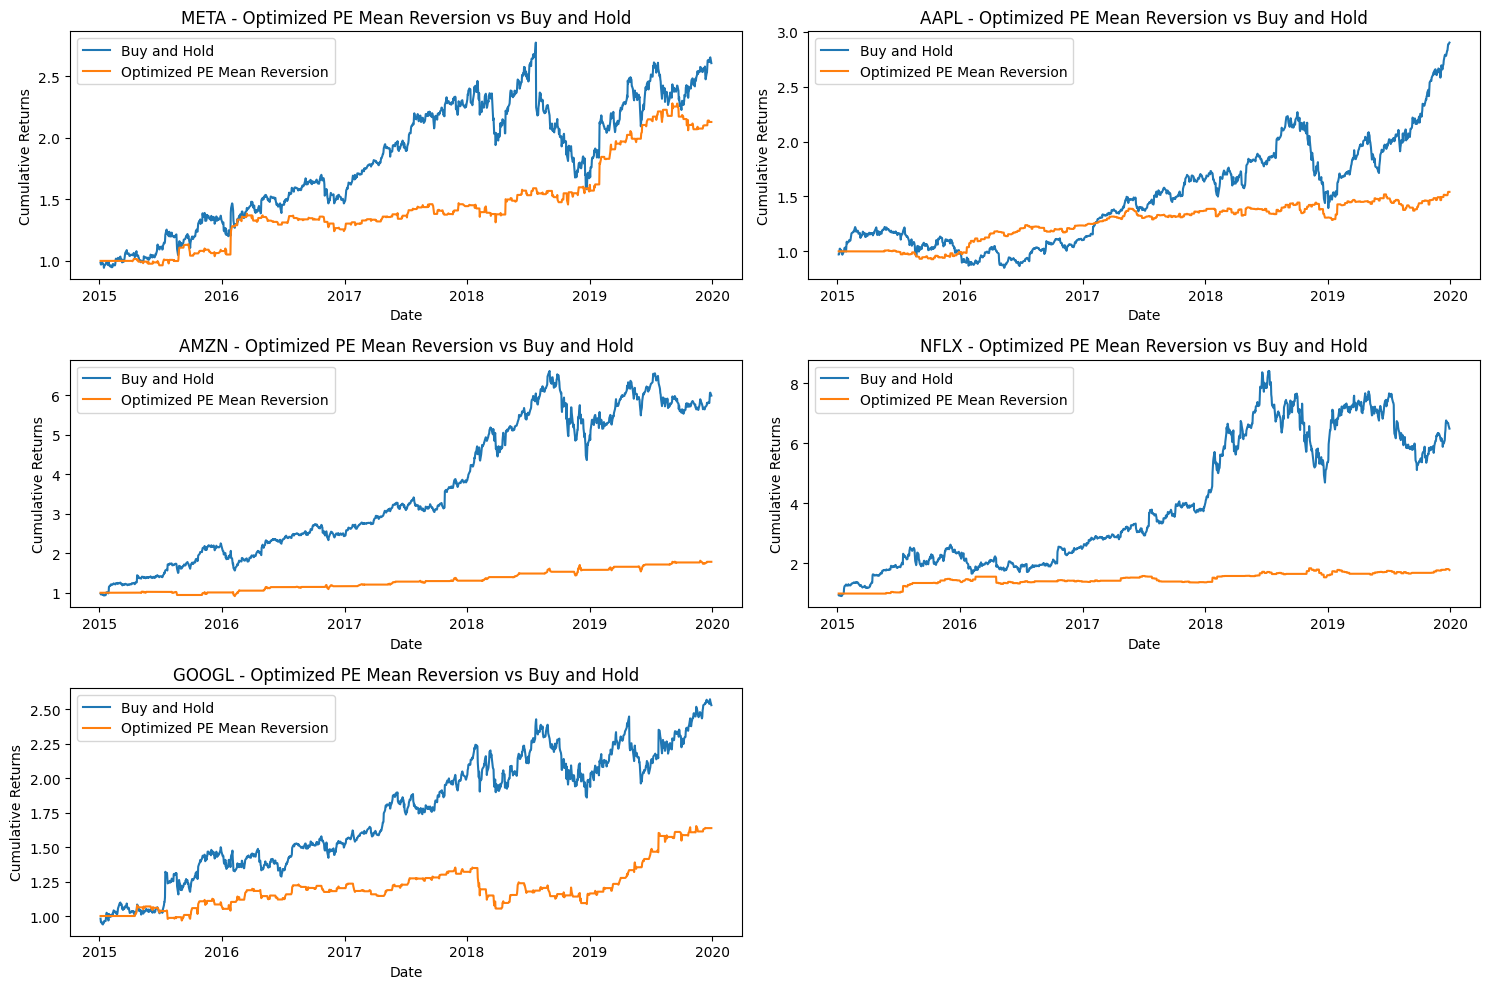

In [10]:
def pe_mean_reversion_strategy(tickers, start, end, window_range, std_dev_range):
    results = {}

    for ticker in tickers:
        print(f"Processing {ticker}...")
        stock = yf.Ticker(ticker)
        df = stock.history(start=start, end=end)

        if df.empty:
            print(f"No data available for {ticker}. Skipping.")
            continue

        pe_ratio = stock.info.get('forwardPE')
        if pe_ratio is None:
            print(f"Warning: Forward PE not available for {ticker}. Skipping.")
            continue
        df['PE_Ratio'] = pe_ratio

        best_sharpe = -np.inf
        best_params = None
        best_strategy_returns = None

        for window, std_dev in product(window_range, std_dev_range):
            df['PE_MA'] = df['PE_Ratio'].rolling(window=window).mean()
            df['PE_STD'] = df['PE_Ratio'].rolling(window=window).std()

            df['Upper_Band'] = df['PE_MA'] + (std_dev * df['PE_STD'])
            df['Lower_Band'] = df['PE_MA'] - (std_dev * df['PE_STD'])
            df['Signal'] = np.where(df['PE_Ratio'] > df['Upper_Band'], 1, 
                                    np.where(df['PE_Ratio'] < df['Lower_Band'], -1, 0))

            df['Returns'] = df['Close'].pct_change()
            df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

            sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()

            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_params = (window, std_dev)
                best_strategy_returns = df['Strategy_Returns']

        cumulative_returns = (1 + df['Returns']).cumprod()
        cumulative_strategy_returns = (1 + best_strategy_returns).cumprod()

        results[ticker] = {
            'Buy_and_Hold': cumulative_returns.iloc[-1],
            'Strategy': cumulative_strategy_returns.iloc[-1],
            'Sharpe_Ratio': best_sharpe,
            'Best_Params': best_params,
            'Cumulative_Returns': cumulative_returns,
            'Cumulative_Strategy_Returns': cumulative_strategy_returns
        }

    return results

# Main execution
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
benchmark_symbol = "^GSPC"
start="2015-01-01"
end="2019-12-31"
period = "1y"

# Define ranges for optimization
window_range = range(10, 101, 10)  # 10, 20, ..., 100
std_dev_range = [0.5, 1, 1.5, 2, 2.5, 3]

results = pe_mean_reversion_strategy(tickers, start, end, window_range, std_dev_range)

# Print results
for ticker, data in results.items():
    print(f"\n{ticker}:")
    print(f"Buy and Hold Returns: {data['Buy_and_Hold']:.2f}")
    print(f"Strategy Returns: {data['Strategy']:.2f}")
    print(f"Sharpe Ratio: {data['Sharpe_Ratio']:.2f}")
    print(f"Best Parameters (Window, Std Dev): {data['Best_Params']}")

# Plot results
plt.figure(figsize=(15, 10))
for i, (ticker, data) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(data['Cumulative_Returns'], label='Buy and Hold')
    plt.plot(data['Cumulative_Strategy_Returns'], label='Optimized PE Mean Reversion')
    plt.title(f'{ticker} - Optimized PE Mean Reversion vs Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()

plt.tight_layout()
plt.show()

#### Vary S.D. of both upper and lower band

In [21]:
def pe_mean_reversion_grid_search(tickers, start, end, window_range, std_dev_range, separate_std=False):
    results = {}

    for ticker in tickers:
        print(f"Processing {ticker}...")
        stock = yf.Ticker(ticker)
        df = stock.history(start=start, end=end)

        if df.empty:
            print(f"No data available for {ticker}. Skipping.")
            continue

        pe_ratio = stock.info.get('forwardPE')
        if pe_ratio is None:
            print(f"Warning: Forward PE not available for {ticker}. Skipping.")
            continue
        df['PE_Ratio'] = pe_ratio

        best_sharpe = -np.inf
        best_params = None
        best_strategy_returns = None

        # Use grid search with separate or single std_dev
        if separate_std:
            grid = product(window_range, std_dev_range, std_dev_range)  # Separate upper and lower std_dev
        else:
            grid = product(window_range, std_dev_range)  # Single std_dev for both bands

        for params in grid:
            if separate_std:
                window, upper_std_dev, lower_std_dev = params
            else:
                window, std_dev = params
                upper_std_dev = lower_std_dev = std_dev

            df['PE_MA'] = df['PE_Ratio'].rolling(window=window).mean()
            df['PE_STD'] = df['PE_Ratio'].rolling(window=window).std()

            df['Upper_Band'] = df['PE_MA'] + (upper_std_dev * df['PE_STD'])
            df['Lower_Band'] = df['PE_MA'] - (lower_std_dev * df['PE_STD'])
            df['Signal'] = np.where(df['PE_Ratio'] > df['Upper_Band'], -1, 
                                    np.where(df['PE_Ratio'] < df['Lower_Band'], 1, 0))

            df['Returns'] = df['Close'].pct_change()
            df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

            sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()

            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_params = (window, upper_std_dev, lower_std_dev) if separate_std else (window, std_dev)
                best_strategy_returns = df['Strategy_Returns']

        cumulative_returns = (1 + df['Returns']).cumprod()
        cumulative_strategy_returns = (1 + best_strategy_returns).cumprod()

        results[ticker] = {
            'Buy_and_Hold': cumulative_returns.iloc[-1],
            'Strategy': cumulative_strategy_returns.iloc[-1],
            'Sharpe_Ratio': best_sharpe,
            'Best_Params': best_params,
            'Cumulative_Returns': cumulative_returns,
            'Cumulative_Strategy_Returns': cumulative_strategy_returns
        }

    return results

Processing META...
Processing AAPL...
Processing AMZN...
Processing NFLX...
Processing GOOGL...


/var/folders/18/wfgp52jj6rb7zsb485dxh1dh0000gn/T/ipykernel_3904/2907498101.py:47: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()



META:
Buy and Hold Returns: 2.61
Strategy Returns: 1.00
Sharpe Ratio: 0.05
Best Parameters (Window, Upper Std Dev, Lower Std Dev): (10, 0.5, 0.5)

AAPL:
Buy and Hold Returns: 2.90
Strategy Returns: 1.77
Sharpe Ratio: 1.01
Best Parameters (Window, Upper Std Dev, Lower Std Dev): (50, 0.5, 0.5)

AMZN:
Buy and Hold Returns: 5.99
Strategy Returns: 2.20
Sharpe Ratio: 1.02
Best Parameters (Window, Upper Std Dev, Lower Std Dev): (20, 0.5, 0.5)

NFLX:
Buy and Hold Returns: 6.49
Strategy Returns: 2.24
Sharpe Ratio: 0.98
Best Parameters (Window, Upper Std Dev, Lower Std Dev): (60, 0.5, 0.5)

GOOGL:
Buy and Hold Returns: 2.53
Strategy Returns: 1.57
Sharpe Ratio: 0.87
Best Parameters (Window, Upper Std Dev, Lower Std Dev): (80, 0.5, 0.5)


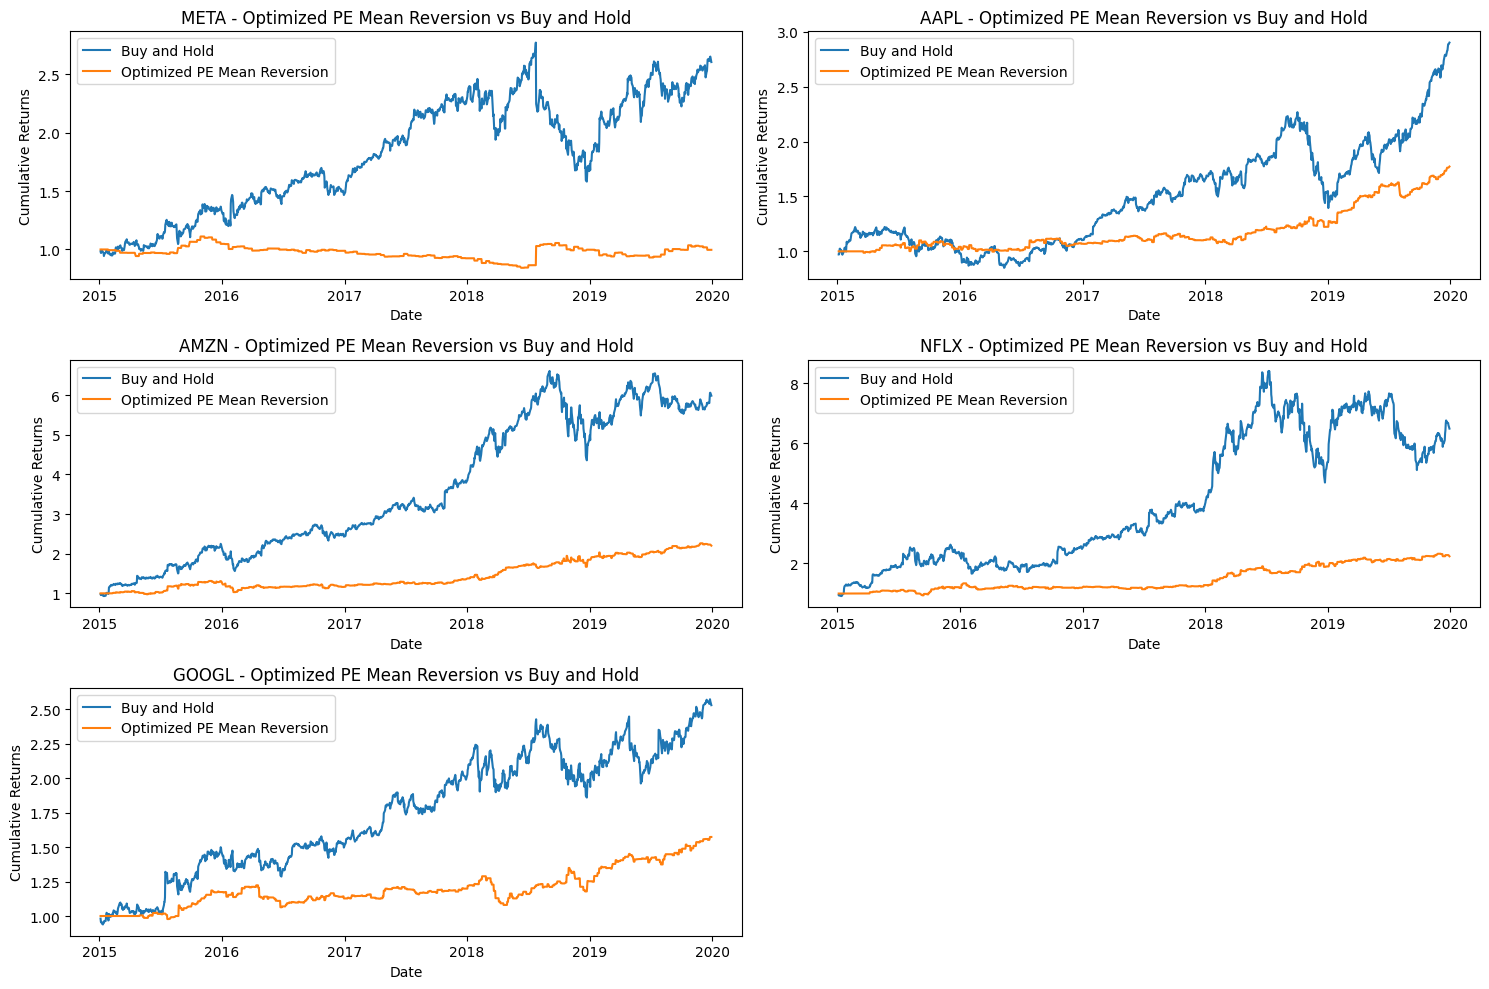

In [22]:
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start = "2015-01-01"
end = "2019-12-31"

# Define ranges for optimization
window_range = range(10, 101, 10)  # 10, 20, ..., 100
std_dev_range = [0.5, 1, 1.5, 2, 2.5]

# Set separate_std to True for different std_dev values for upper and lower bands
results = pe_mean_reversion_grid_search(tickers, start, end, window_range, std_dev_range, separate_std=True)

# Print results
for ticker, data in results.items():
    print(f"\n{ticker}:")
    print(f"Buy and Hold Returns: {data['Buy_and_Hold']:.2f}")
    print(f"Strategy Returns: {data['Strategy']:.2f}")
    print(f"Sharpe Ratio: {data['Sharpe_Ratio']:.2f}")
    print(f"Best Parameters (Window, Upper Std Dev, Lower Std Dev): {data['Best_Params']}")

# Plot results
plt.figure(figsize=(15, 10))
for i, (ticker, data) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(data['Cumulative_Returns'], label='Buy and Hold')
    plt.plot(data['Cumulative_Strategy_Returns'], label='Optimized PE Mean Reversion')
    plt.title(f'{ticker} - Optimized PE Mean Reversion vs Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()

plt.tight_layout()
plt.show()


### Use Z-Score and Find Out Weights

META - Best params: {'window': 30, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 20, 'ma_long': 50}, Sharpe: 0.23
AAPL - Best params: {'window': 30, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 30, 'ma_long': 150}, Sharpe: 0.60
AMZN - Best params: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 10, 'ma_long': 100}, Sharpe: 0.79
NFLX - Best params: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 30, 'ma_long': 100}, Sharpe: 0.83
GOOGL - Best params: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 30, 'ma_long': 50}, Sharpe: 0.13
normalised avg corr: Trend            0.272303
PE_Signal        0.210907
Volume_Signal    0.5167

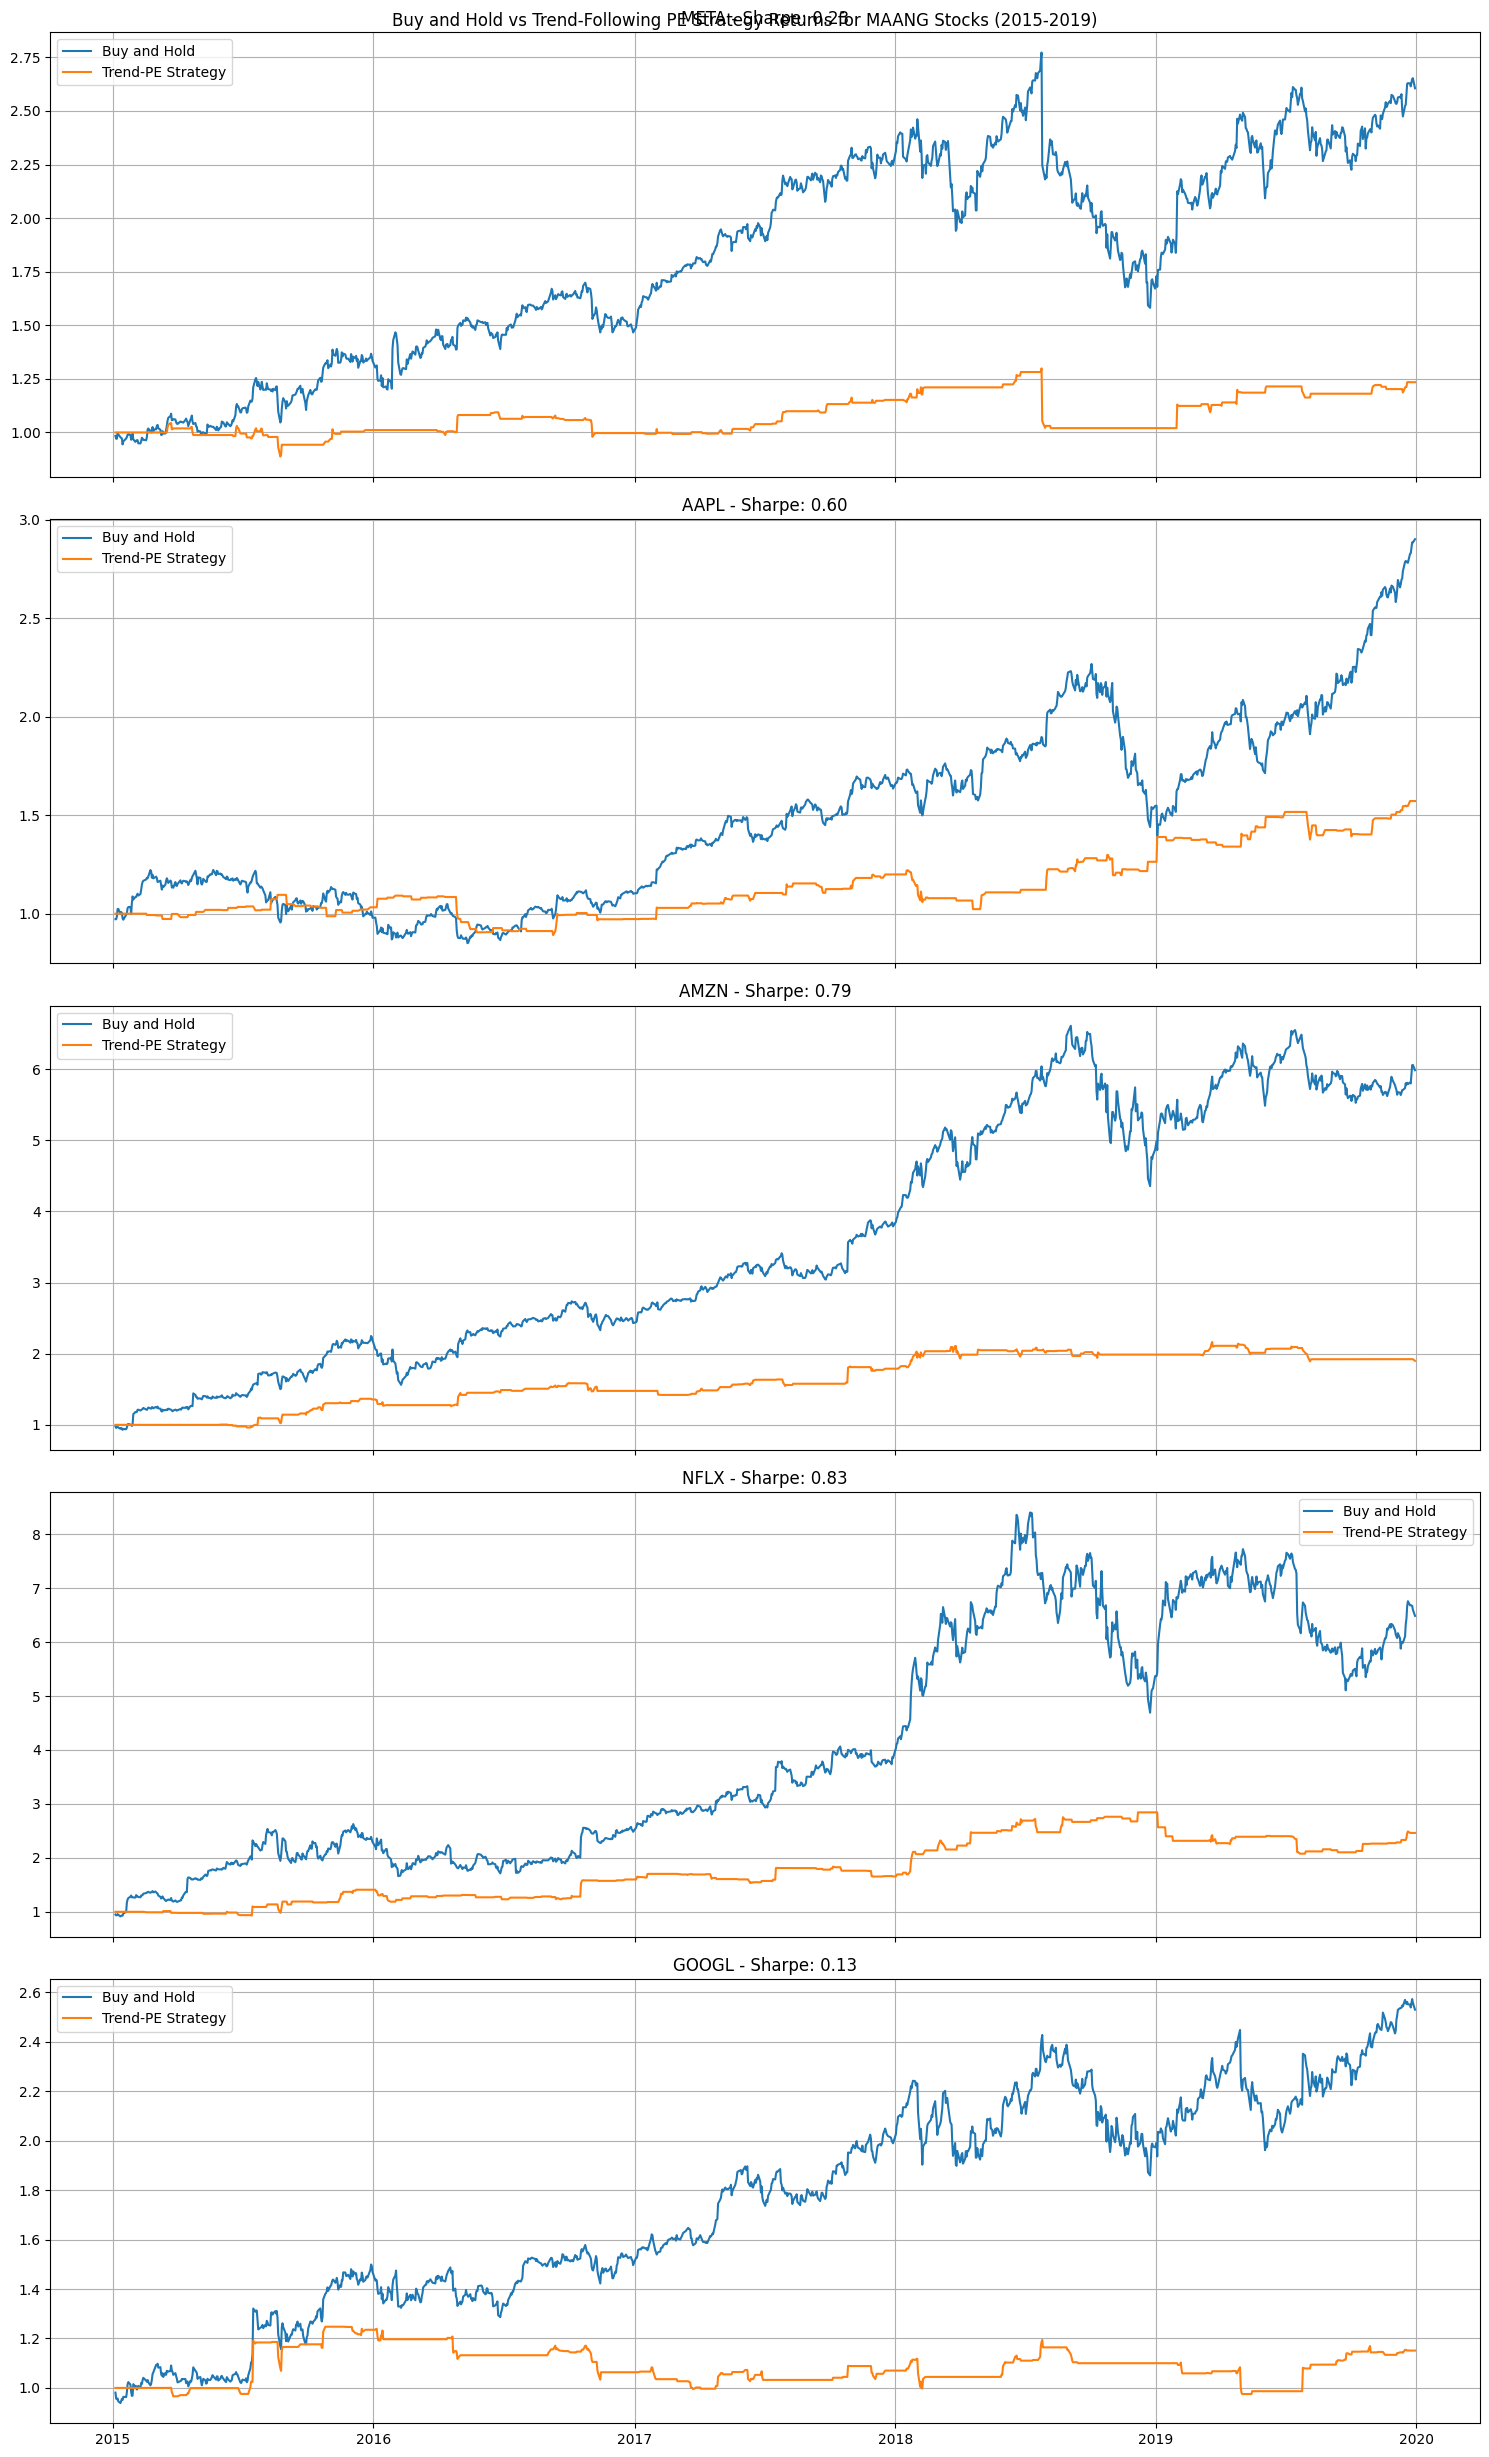


META:
Best parameters: {'window': 30, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 20, 'ma_long': 50}
Sharpe Ratio: 0.23
Buy and Hold Returns: 2.61
Strategy Returns: 1.23

AAPL:
Best parameters: {'window': 30, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 30, 'ma_long': 150}
Sharpe Ratio: 0.60
Buy and Hold Returns: 2.90
Strategy Returns: 1.57

AMZN:
Best parameters: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 10, 'ma_long': 100}
Sharpe Ratio: 0.79
Buy and Hold Returns: 5.99
Strategy Returns: 1.90

NFLX:
Best parameters: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'roe_threshold': 0.1, 'debt_equity_threshold': 1.0, 'ma_short': 30, 'ma_long': 100}
Sharpe Ratio: 0.83
Buy and Hold Returns: 6.49
Strategy Returns: 2.46

GOOGL:
Best parameters: {'window': 21, '

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    if len(returns) < 2:
        return 0
    excess_returns = returns - (risk_free_rate / periods_per_year)
    ann_excess_return = np.mean(excess_returns) * periods_per_year
    ann_volatility = np.std(excess_returns, ddof=1) * np.sqrt(periods_per_year)
    if ann_volatility == 0:
        return 0
    return ann_excess_return / ann_volatility

# Find out correlations
def calculate_signal_correlations(df):
    future_returns = df['Returns'].shift(-1)
    signals = ['Trend', 'PE_Signal', 'Volume_Signal']
    correlations = {}
    for signal in signals:
        if signal in df.columns:
            correlation = np.corrcoef(df[signal].fillna(0), future_returns.fillna(0))[0,1]
            correlations[signal] = abs(correlation)  # Use absolute correlation
    return correlations

def optimize_trend_pe_strategy(ticker, start_date, end_date, param_grid):
    def run_strategy(params):
        window, pe_z_threshold, volume_threshold, roe_threshold, debt_equity_threshold, ma_short, ma_long = params
        df = improved_trend_pe_strategy(ticker, start_date, end_date, window, pe_z_threshold, volume_threshold, roe_threshold, debt_equity_threshold, ma_short, ma_long)
        sharpe_ratio = calculate_sharpe_ratio(df['Strategy_Returns'])
        return sharpe_ratio, params, df

    def improved_trend_pe_strategy(ticker, start_date, end_date, window, pe_z_threshold, volume_threshold, roe_threshold, debt_equity_threshold, ma_short, ma_long):
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        # PE Ratio component
        df['PE_Ratio'] = stock.info.get('forwardPE', stock.info.get('trailingPE'))
        df['PE_MA'] = df['PE_Ratio'].rolling(window=window).mean()
        df['PE_STD'] = df['PE_Ratio'].rolling(window=window).std()
        df['PE_Z'] = (df['PE_Ratio'] - df['PE_MA']) / df['PE_STD']

        # Volume component
        df['Volume_MA'] = df['Volume'].rolling(window=window).mean()
        df['Volume_STD'] = df['Volume'].rolling(window=window).std()
        df['Volume_Z'] = (df['Volume'] - df['Volume_MA']) / df['Volume_STD']

        # Trend following component
        df['MA_Short'] = df['Close'].rolling(window=ma_short).mean()
        df['MA_Long'] = df['Close'].rolling(window=ma_long).mean()

        # Equity component
        df['ROE'] = stock.info.get('returnOnEquity', 0)
        df['Debt_to_Equity'] = stock.info.get('debtToEquity', 0)

        # Signal generation
        df['Trend'] = np.where(df['MA_Short'] > df['MA_Long'], 1, -1)
        df['PE_Signal'] = np.where(df['PE_Z'] < -pe_z_threshold, 1, 
                                   np.where(df['PE_Z'] > pe_z_threshold, -1, 0))
        df['Volume_Signal'] = np.where(df['Volume_Z'] > volume_threshold, 1, 0)

        # df['ROE_Signal'] = np.where(df['ROE'] >= roe_threshold, 1, -1)
        # df['Debt_Equity_Signal'] = np.where(df['Debt_to_Equity'] <= debt_equity_threshold, 1, -1)

        # Combined signal
        df['Signal'] = np.where((df['Trend'] == 1) & (df['PE_Signal'] >= 0) & (df['Volume_Signal'] == 1), 1,
                                np.where((df['Trend'] == -1) & (df['PE_Signal'] == -1), -1, 0))
        
        # Update and run this tomorrow!!!
        # df['Signal'] = np.where((df['Trend'] == 1) & (df['PE_Signal'] >= 0) & (df['Volume_Signal'] == 1) & 
        #                 (df['ROE_Signal'] == 1) & (df['Debt_Equity_Signal'] == 1), 1,
        #         np.where((df['Trend'] == -1) & (df['PE_Signal'] == -1) & 
        #                 ((df['ROE_Signal'] == -1) | (df['Debt_Equity_Signal'] == -1)), -1, 0))

        # Returns calculation
        df['Returns'] = df['Close'].pct_change()
        df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']
        df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
        df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()

        return df

    all_params = list(product(*param_grid.values()))
    results = [run_strategy(params) for params in all_params]
    best_sharpe, best_params, best_df = max(results, key=lambda x: x[0])
    return dict(zip(param_grid.keys(), best_params)), best_sharpe, best_df

# MAANG stocks
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2015-01-01'
end_date = '2019-12-31'

param_grid = {
    'window': [14, 21, 30],
    'pe_z_threshold': [1.0, 1.5, 2.0, 3.0],
    'volume_threshold': [0.5, 1.0, 1.5, 2.0],
    'roe_threshold': [0.10, 0.15, 0.20],
    'debt_equity_threshold': [1.0, 1.5, 2.0],
    'ma_short': [10, 20, 30],
    'ma_long': [50, 100, 150]
}

# Run optimization for each stock
results = {}
all_correlations = []
for ticker in tickers:
    best_params, best_sharpe, best_df = optimize_trend_pe_strategy(ticker, start_date, end_date, param_grid)
    correlations = calculate_signal_correlations(best_df)
    all_correlations.append(correlations)

    results[ticker] = {
        'params': best_params,
        'sharpe': best_sharpe,
        'df': best_df
    }
    print(f"{ticker} - Best params: {best_params}, Sharpe: {best_sharpe:.2f}")

avg_correlations = pd.DataFrame(all_correlations).mean()
normalised_avg_correlations = avg_correlations / avg_correlations.sum()
print("normalised avg corr:", normalised_avg_correlations)
print(all_correlations)

# Plotting
fig, axs = plt.subplots(len(tickers), 1, figsize=(15, 5*len(tickers)), sharex=True)
fig.suptitle('Buy and Hold vs Trend-Following PE Strategy Returns for MAANG Stocks (2015-2019)')

for i, (ticker, data) in enumerate(results.items()):
    df = data['df']
    axs[i].plot(df.index, df['Cumulative_Returns'], label='Buy and Hold')
    axs[i].plot(df.index, df['Cumulative_Strategy_Returns'], label='Trend-PE Strategy')
    axs[i].set_title(f'{ticker} - Sharpe: {data["sharpe"]:.2f}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Print final results
for ticker, data in results.items():
    print(f"\n{ticker}:")
    print(f"Best parameters: {data['params']}")
    print(f"Sharpe Ratio: {data['sharpe']:.2f}")
    print(f"Buy and Hold Returns: {data['df']['Cumulative_Returns'].iloc[-1]:.2f}")
    print(f"Strategy Returns: {data['df']['Cumulative_Strategy_Returns'].iloc[-1]:.2f}")

Signal Generation
- Buy: When trend is bullish, PE ratio is not extremely high, and volume is above threshold
- Sell: When trend is bearish, PE ratio is high
- Hold: All other cases

- Trend: 0.272303
- PE_Signal: 0.210907
- Volume_Signal: 0.516790

These are the weights that should be applied to the combined signal generation.

### Weighted Signal

META - Best params: {'window': 30, 'pe_z_threshold': 1.0, 'volume_threshold': 1.5, 'ma_short': 20, 'ma_long': 50}, Sharpe: 0.61
AAPL - Best params: {'window': 14, 'pe_z_threshold': 1.0, 'volume_threshold': 1.5, 'ma_short': 20, 'ma_long': 150}, Sharpe: 0.47
AMZN - Best params: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 2.0, 'ma_short': 20, 'ma_long': 100}, Sharpe: 0.79
NFLX - Best params: {'window': 14, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'ma_short': 10, 'ma_long': 50}, Sharpe: 0.36
GOOGL - Best params: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 1.5, 'ma_short': 30, 'ma_long': 50}, Sharpe: 0.56


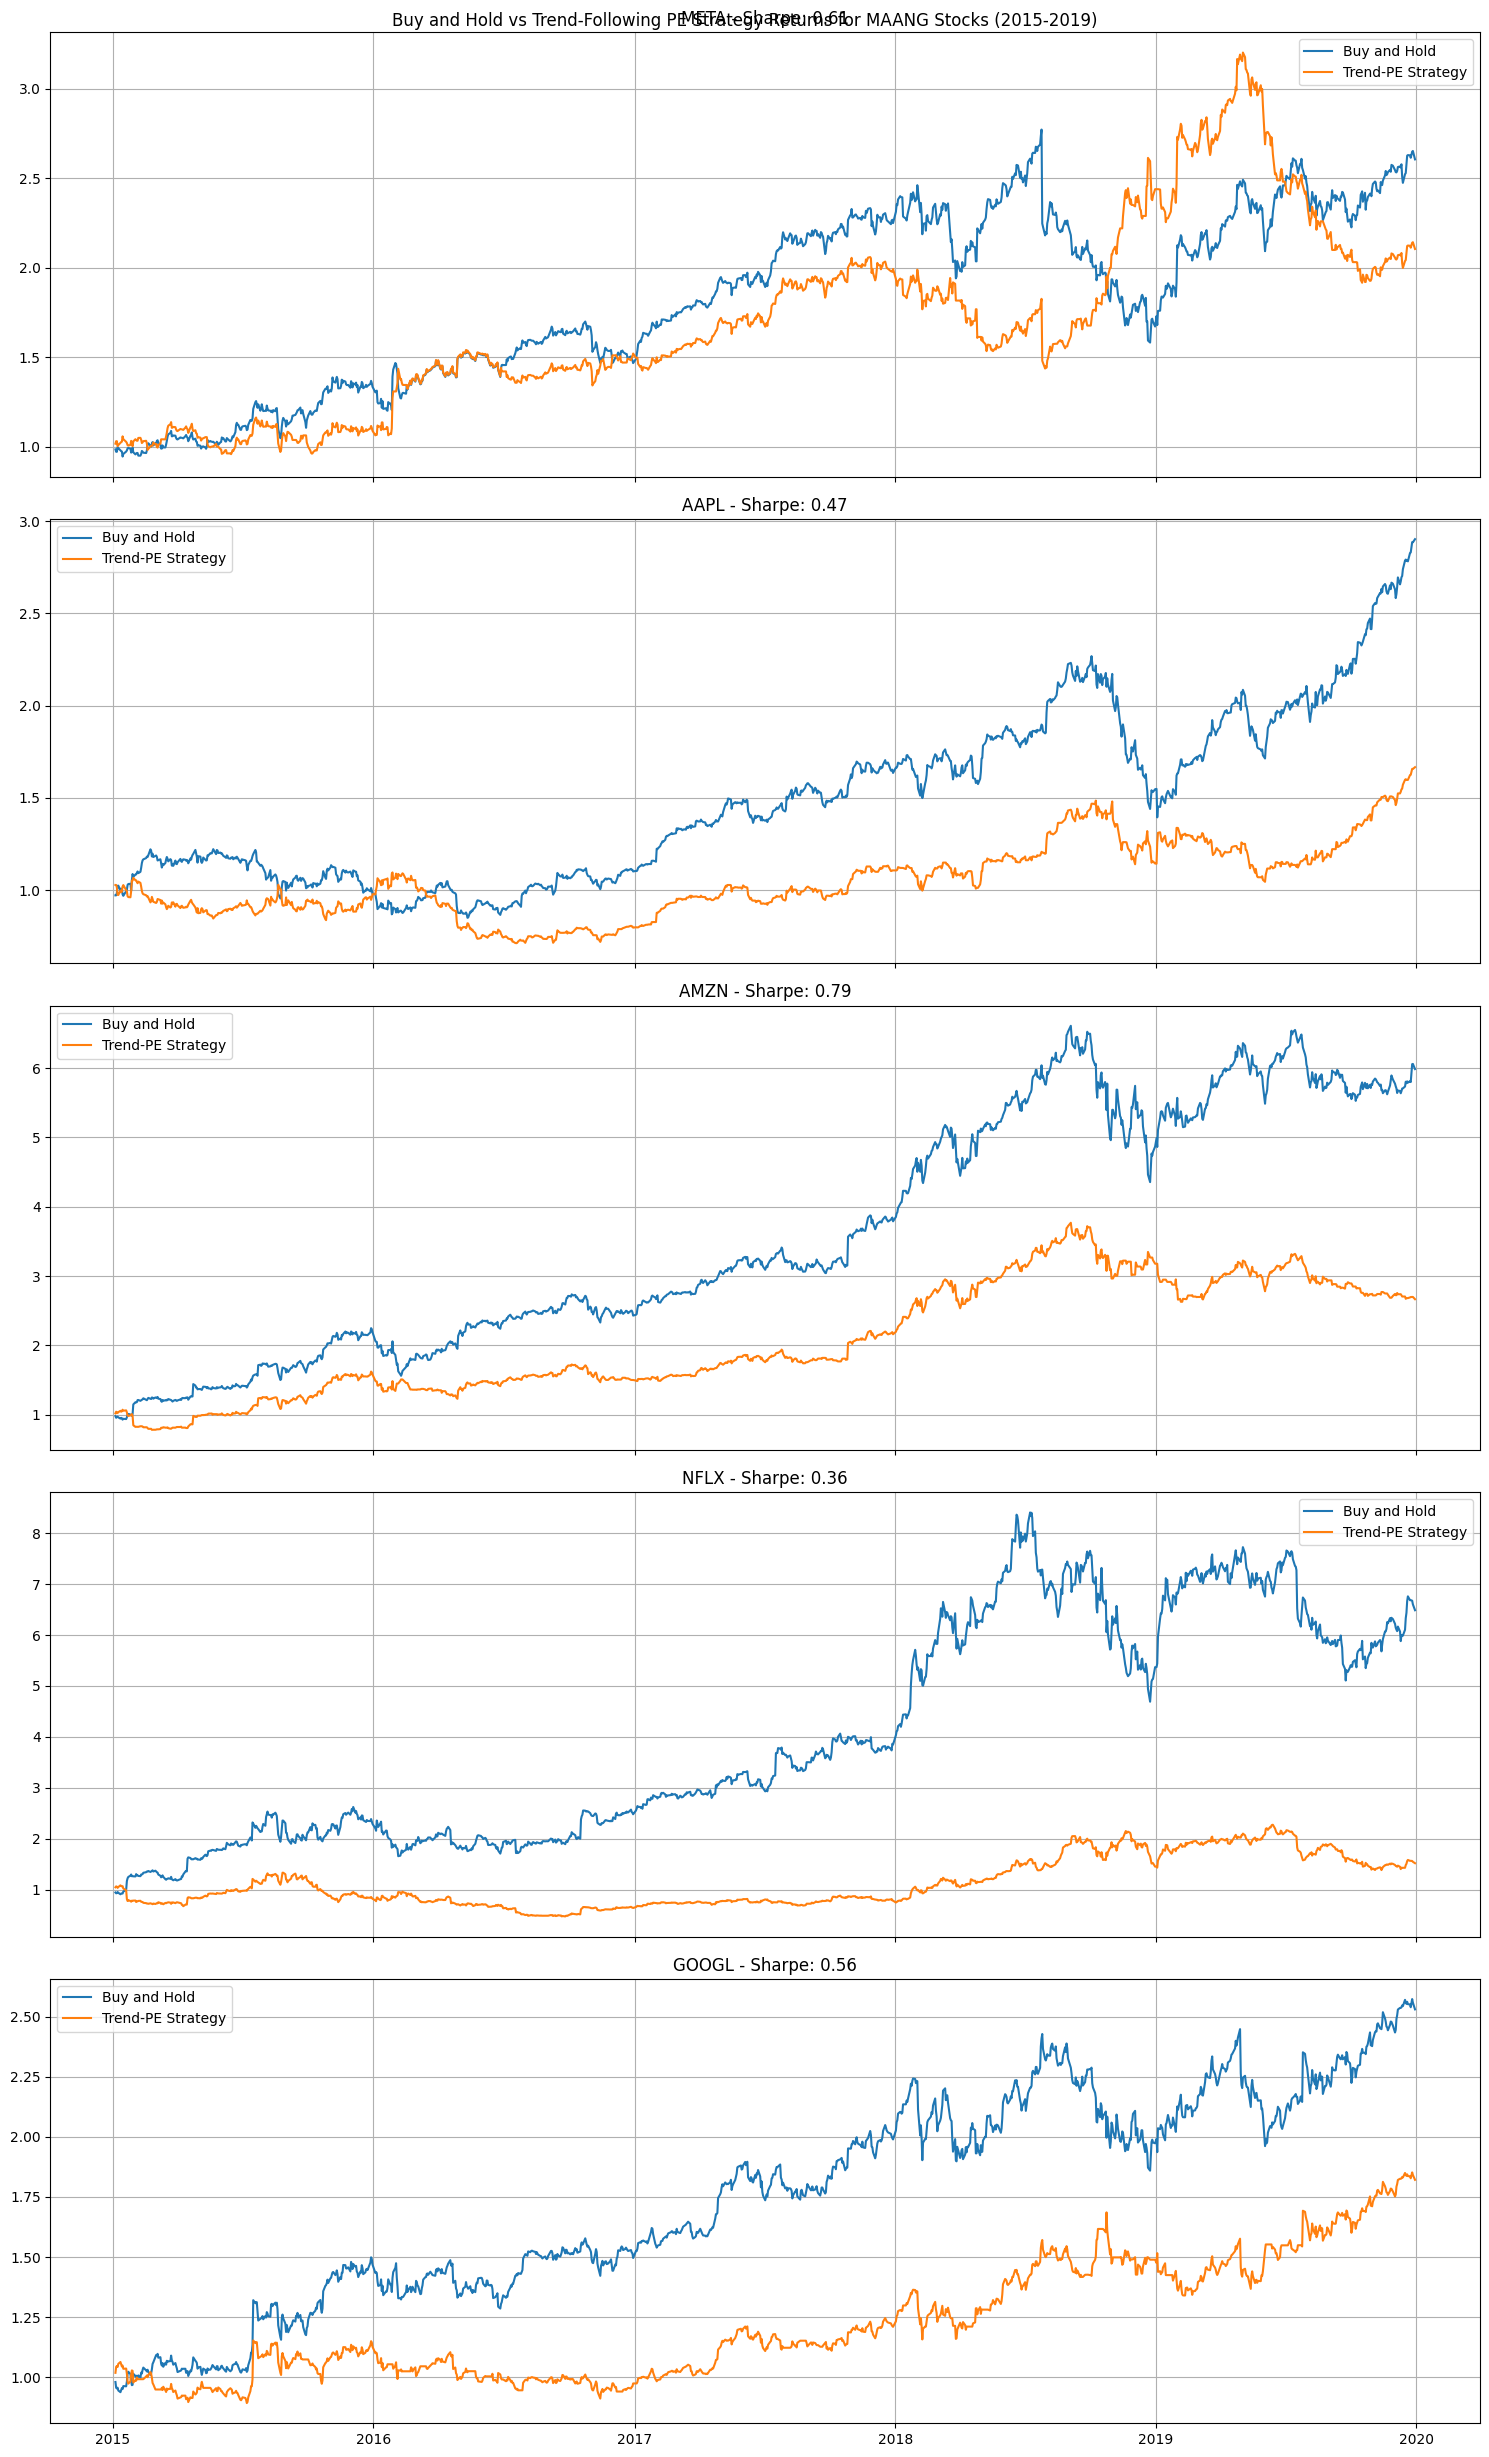


META:
Best parameters: {'window': 30, 'pe_z_threshold': 1.0, 'volume_threshold': 1.5, 'ma_short': 20, 'ma_long': 50}
Sharpe Ratio: 0.61
Buy and Hold Returns: 2.61
Strategy Returns: 2.10

AAPL:
Best parameters: {'window': 14, 'pe_z_threshold': 1.0, 'volume_threshold': 1.5, 'ma_short': 20, 'ma_long': 150}
Sharpe Ratio: 0.47
Buy and Hold Returns: 2.90
Strategy Returns: 1.67

AMZN:
Best parameters: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 2.0, 'ma_short': 20, 'ma_long': 100}
Sharpe Ratio: 0.79
Buy and Hold Returns: 5.99
Strategy Returns: 2.67

NFLX:
Best parameters: {'window': 14, 'pe_z_threshold': 1.0, 'volume_threshold': 0.5, 'ma_short': 10, 'ma_long': 50}
Sharpe Ratio: 0.36
Buy and Hold Returns: 6.49
Strategy Returns: 1.52

GOOGL:
Best parameters: {'window': 21, 'pe_z_threshold': 1.0, 'volume_threshold': 1.5, 'ma_short': 30, 'ma_long': 50}
Sharpe Ratio: 0.56
Buy and Hold Returns: 2.53
Strategy Returns: 1.82


In [12]:
def weighted_trend_pe_strategy(ticker, start_date, end_date, param_grid):
    def run_strategy(params):
        window, pe_z_threshold, volume_threshold, ma_short, ma_long = params
        df = improved_trend_pe_strategy(ticker, start_date, end_date, window, pe_z_threshold, volume_threshold, ma_short, ma_long)
        sharpe_ratio = calculate_sharpe_ratio(df['Strategy_Returns'])
        return sharpe_ratio, params, df
    
    signal_weights = {
    'Trend': 0.272303,
    'PE_Signal': 0.210907,
    'Volume_Signal': 0.516790
    }

    def improved_trend_pe_strategy(ticker, start_date, end_date, window, pe_z_threshold, volume_threshold, ma_short, ma_long):
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        # PE Ratio component
        df['PE_Ratio'] = stock.info.get('forwardPE', stock.info.get('trailingPE'))
        df['PE_MA'] = df['PE_Ratio'].rolling(window=window).mean()
        df['PE_STD'] = df['PE_Ratio'].rolling(window=window).std()
        df['PE_Z'] = (df['PE_Ratio'] - df['PE_MA']) / df['PE_STD']

        # Volume component
        df['Volume_MA'] = df['Volume'].rolling(window=window).mean()
        df['Volume_STD'] = df['Volume'].rolling(window=window).std()
        df['Volume_Z'] = (df['Volume'] - df['Volume_MA']) / df['Volume_STD']

        # Trend following component
        df['MA_Short'] = df['Close'].rolling(window=ma_short).mean()
        df['MA_Long'] = df['Close'].rolling(window=ma_long).mean()

        # Equity component
        # df['ROE'] = stock.info.get('returnOnEquity', 0)
        # df['Debt_to_Equity'] = stock.info.get('debtToEquity', 0)

        # Signal generation
        df['Trend'] = np.where(df['MA_Short'] > df['MA_Long'], 1, -1)
        df['PE_Signal'] = np.where(df['PE_Z'] < -pe_z_threshold, 1, 
                                   np.where(df['PE_Z'] > pe_z_threshold, -1, 0))
        df['Volume_Signal'] = np.where(df['Volume_Z'] > volume_threshold, 1, 0)

        # df['ROE_Signal'] = np.where(df['ROE'] >= roe_threshold, 1, -1)
        # df['Debt_Equity_Signal'] = np.where(df['Debt_to_Equity'] <= debt_equity_threshold, 1, -1)

        # Weighted signal
        df['Weighted_Signal'] = (
            signal_weights['Trend'] * df['Trend'] +
            signal_weights['PE_Signal'] * df['PE_Signal'] +
            signal_weights['Volume_Signal'] * df['Volume_Signal']
        )

        # Generate signal
        '''
        1 (buy) when the weighted sum is greater than 0.2
        -1 (sell) when the weighted sum is less than -0.2
        0 (neutral) when the weighted sum is between -0.2 and 0.2

        thresholds can be adjusted
        '''

        df['Signal'] = np.where(df['Weighted_Signal'] > 0.2, 1,
                        np.where(df['Weighted_Signal'] < -0.2, -1, 0))

        # Returns calculation
        df['Returns'] = df['Close'].pct_change()
        df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']
        df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
        df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()

        return df

    all_params = list(product(*param_grid.values()))
    results = [run_strategy(params) for params in all_params]
    best_sharpe, best_params, best_df = max(results, key=lambda x: x[0])
    return dict(zip(param_grid.keys(), best_params)), best_sharpe, best_df

# MAANG stocks
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2015-01-01'
end_date = '2019-12-31'

param_grid = {
    'window': [14, 21, 30],
    'pe_z_threshold': [1.0, 1.5, 2.0, 3.0],
    'volume_threshold': [0.5, 1.0, 1.5, 2.0],
    # 'roe_threshold': [0.10, 0.15, 0.20],
    # 'debt_equity_threshold': [1.0, 1.5, 2.0],
    'ma_short': [10, 20, 30],
    'ma_long': [50, 100, 150]
}

# Run optimization for each stock
results = {}
all_correlations = []
for ticker in tickers:
    best_params, best_sharpe, best_df = weighted_trend_pe_strategy(ticker, start_date, end_date, param_grid)
    # correlations = calculate_signal_correlations(best_df)
    # all_correlations.append(correlations)

    results[ticker] = {
        'params': best_params,
        'sharpe': best_sharpe,
        'df': best_df
    }
    print(f"{ticker} - Best params: {best_params}, Sharpe: {best_sharpe:.2f}")

# Plotting
fig, axs = plt.subplots(len(tickers), 1, figsize=(15, 5*len(tickers)), sharex=True)
fig.suptitle('Buy and Hold vs Trend-Following PE Strategy Returns for MAANG Stocks (2015-2019)')

for i, (ticker, data) in enumerate(results.items()):
    df = data['df']
    axs[i].plot(df.index, df['Cumulative_Returns'], label='Buy and Hold')
    axs[i].plot(df.index, df['Cumulative_Strategy_Returns'], label='Trend-PE Strategy')
    axs[i].set_title(f'{ticker} - Sharpe: {data["sharpe"]:.2f}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Print final results
for ticker, data in results.items():
    print(f"\n{ticker}:")
    print(f"Best parameters: {data['params']}")
    print(f"Sharpe Ratio: {data['sharpe']:.2f}")
    print(f"Buy and Hold Returns: {data['df']['Cumulative_Returns'].iloc[-1]:.2f}")
    print(f"Strategy Returns: {data['df']['Cumulative_Strategy_Returns'].iloc[-1]:.2f}")